In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import mpld3
import random as rn

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 16})

In [2]:
N=100
mu = 0
sigma = 1

np.random.seed(2)
rn.seed(2)

y=np.empty(0)
X=np.empty([0,6])
for i in range(N):
    Z1= rn.normalvariate(mu,sigma)
    Z2= rn.normalvariate(mu,sigma)
    y = np.append(y, 3*Z1-1.5*Z2+2*rn.normalvariate(mu,sigma))
    Xarr = np.array([Z1,Z1,Z1,Z2,Z2,Z2])+ np.random.normal(mu, sigma,6)/5
    X = np.vstack ((X, Xarr.tolist()))


In [3]:
eps = 5e-3  # the smaller it is the longer is the path
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

In [4]:
X.shape, y.shape, alphas_lasso.shape, coefs_lasso.shape


((100, 6), (100,), (100,), (6, 100))

In [5]:
def lasso_with_sklearn(X, y, l1_reg=1):
    from sklearn.linear_model import Lasso
    n = X.shape[0]
    sklearn_lasso = Lasso(alpha=n*l1_reg, fit_intercept=False, normalize=False)
    sklearn_lasso.fit(X, y)
    return sklearn_lasso
sklearn_lasso = lasso_with_sklearn(X, y, 1)
sklearn_lasso.coef_

array([ 0.,  0.,  0., -0., -0., -0.])

In [16]:
from numpy.linalg import inv
def init_w(X, y, alpha):
    di = alpha * np.identity(np.size(X,1))
    XtX = np.dot(X.T, X)
    w = np.dot(inv(XtX + di), np.dot(X.T, y))
    return w

def soft(a, b):
    return np.sign(a) * abs(abs(a) - b)
    
def shooting_coords(X, y, alpha):
    w = init_w(X, y, alpha)
    maxIter = 300
    it = 0
    
    m = 100
    n = 6
    
    while it < maxIter:
        it = it + 1
        for j in range(0, n):
            a_j = 0
            for i in range(0, m):
                a_j = a_j + X[i, j] * X[i, j]
            a_j = 2 * a_j
            c_j = 0
            for i in range(0, m):
                c_j = X[i, j] * (y[i] - np.dot(w.T, X[i,:]) + w[j] * X[i, j])
            c_j = 2 * c_j
            
            w[j] = 0
            if a_j != 0 and c_j != 0:
                w[j] = soft(c_j / a_j, alpha / a_j)
            
    return w

In [17]:
w = shooting_coords(X, y, 1)
w

array([ 0.00669024, -0.00400941, -0.00221879, -0.13088416, -0.14154292,
       -0.14289558])

In [18]:
#w = shooting_coords(X, y, 0.0008)
coefs_shooting = []
for i in alphas_lasso :
    coefs_shooting.append(shooting_coords(X, y, i))
coefs_shooting = np.array(coefs_shooting).T


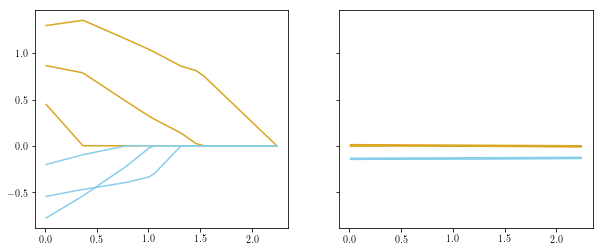

In [19]:
from itertools import cycle
figsize = plt.figaspect(1/2.5)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize) 
colors = cycle(['goldenrod', 'goldenrod', 'goldenrod', 'skyblue', 'skyblue', 'skyblue']) 
for coef_l, c in zip(coefs_lasso,colors):
    l1 = ax1.plot(alphas_lasso, coef_l, c=c)
    

for coef_e, c in zip(coefs_shooting, colors):
    l2 = ax2.plot(alphas_lasso, coef_e, c=c)